In [1]:
# importing dependices

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
# read the dataset
data = pd.read_csv('data.csv',encoding='iso-8859-1')

In [4]:
# copy the dataframe
df = data.copy()

# Information of the Dataframe

In [5]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# missing null values in the dataframe
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# dropping the nan values in the CustomerID column
df = df.dropna(subset=['CustomerID'])

In [8]:
for col in df.columns:
  print("="*100)
  print(f"{col} : \n")
  print(f"number of unique values : {df[col].nunique()}")
  print(f"total rows in the column : {df.shape[0]}")
print("="*100)

InvoiceNo : 

number of unique values : 22190
total rows in the column : 406829
StockCode : 

number of unique values : 3684
total rows in the column : 406829
Description : 

number of unique values : 3896
total rows in the column : 406829
Quantity : 

number of unique values : 436
total rows in the column : 406829
InvoiceDate : 

number of unique values : 20460
total rows in the column : 406829
UnitPrice : 

number of unique values : 620
total rows in the column : 406829
CustomerID : 

number of unique values : 4372
total rows in the column : 406829
Country : 

number of unique values : 37
total rows in the column : 406829


In [9]:
# find the count  negative and zero  in the dataframe
for col in df.select_dtypes(exclude='object').columns:
  print(f"{col} : \n")
  print(f"Number of negative values: {(df[col] < 0).sum()}")
  print(f"Number of zero values: {(df[col] == 0).sum()}")
  print()
  print("="*100)

Quantity : 

Number of negative values: 8905
Number of zero values: 0

UnitPrice : 

Number of negative values: 0
Number of zero values: 40

CustomerID : 

Number of negative values: 0
Number of zero values: 0



In [10]:
df = df[df['UnitPrice']!=0]

In [11]:
df['Quantity'] = df['Quantity'].abs()

In [12]:
# find the count  negative and zero  in the dataframe
for col in df.select_dtypes(exclude='object').columns:
  print(f"{col} : \n")
  print(f"Number of negative values: {(df[col] < 0).sum()}")
  print(f"Number of zero values: {(df[col] == 0).sum()}")
  print()
  print("="*100)

Quantity : 

Number of negative values: 0
Number of zero values: 0

UnitPrice : 

Number of negative values: 0
Number of zero values: 0

CustomerID : 

Number of negative values: 0
Number of zero values: 0



In [13]:
df.drop_duplicates(inplace=True)

In [14]:
print(f" the shape of raw dataframe is {data.shape} \n the shape of new dataframe is {df.shape} \n so far we cleaned {round((100 -(df.shape[0]*100)/data.shape[0]),1)}% of the data")

 the shape of raw dataframe is (541909, 8) 
 the shape of new dataframe is (401564, 8) 
 so far we cleaned 25.9% of the data


Dropped about 29% of records during cleaning

# Feature Engineering

In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Create RFM table
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum',  # Monetary
}).reset_index()
rfm_df = rfm_df.drop(columns=['CustomerID'])
rfm_df.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

In [16]:
rfm_df.head()

,Recency,Frequency,Monetary
0,326,2,154367.20
1,2,7,4310.00
2,75,4,1797.24
3,19,1,1757.55
4,310,1,334.40


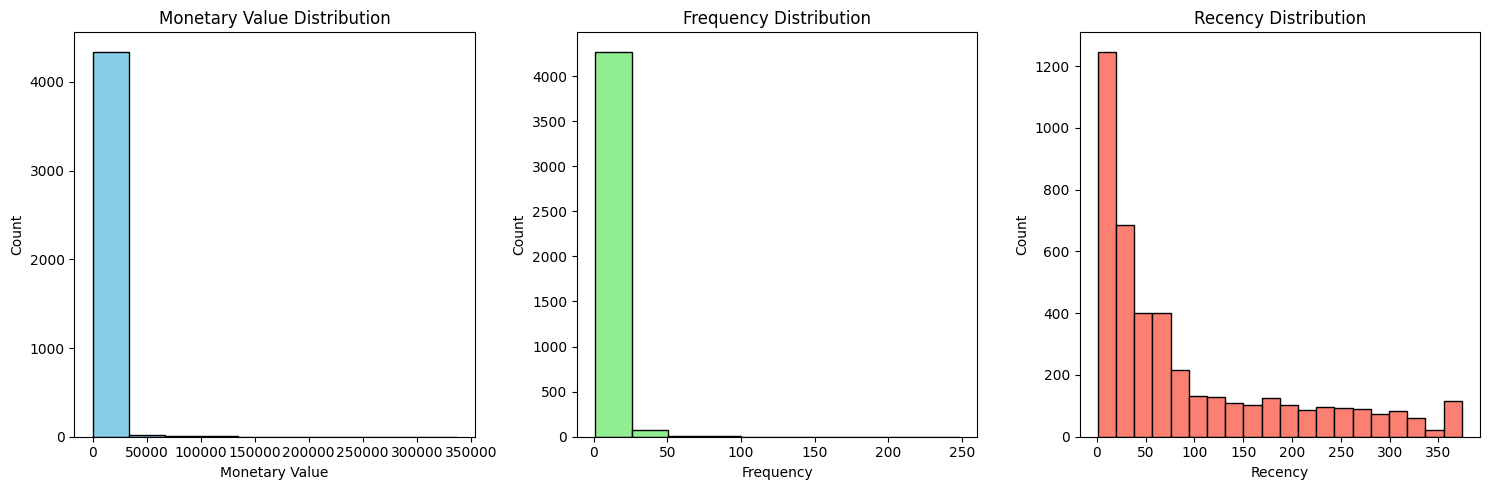

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(rfm_df['Monetary'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(rfm_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(rfm_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

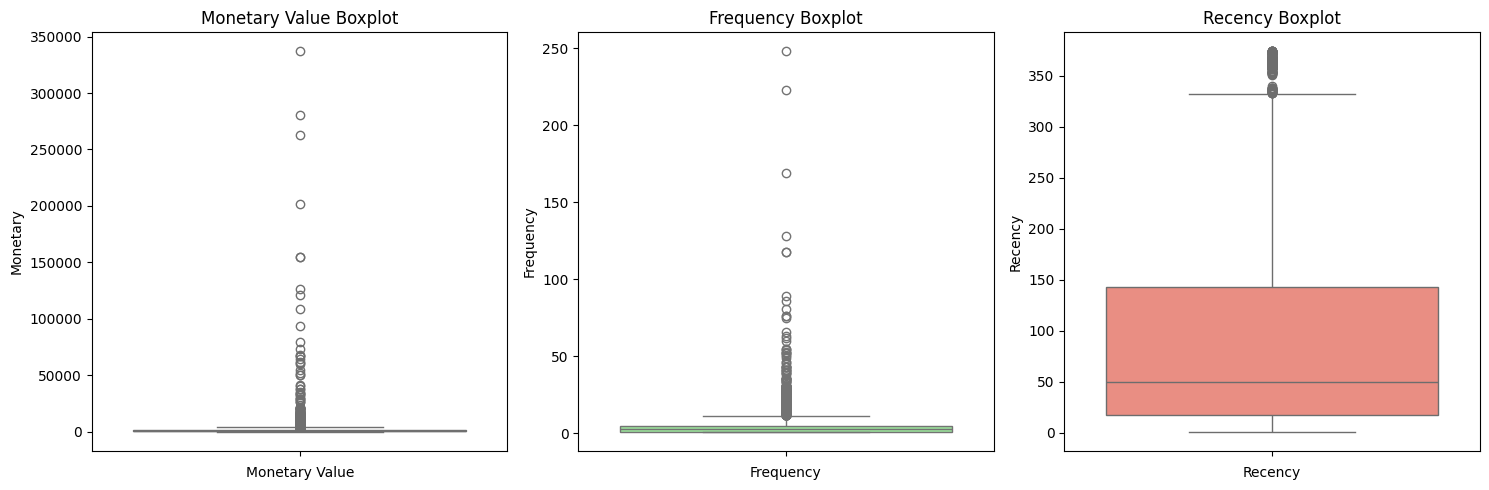

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=rfm_df['Monetary'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=rfm_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=rfm_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [19]:
def detect_outliers(column, threshold=1.5):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return (column < lower_bound) | (column > upper_bound)

In [20]:
# Detect outliers for each RFM column
recency_outliers = detect_outliers(rfm_df['Recency'])
frequency_outliers = detect_outliers(rfm_df['Frequency'])
monetary_outliers = detect_outliers(rfm_df['Monetary'])

In [21]:
# Create separate dataframes for outliers and non-outliers
non_outlier_rfm_df = rfm_df[~(recency_outliers | frequency_outliers | monetary_outliers)].copy()
outlier_rfm_recency_df = rfm_df[recency_outliers].copy()
outlier_rfm_frequency_df = rfm_df[frequency_outliers].copy()
outlier_rfm_monetary_df = rfm_df[monetary_outliers].copy()

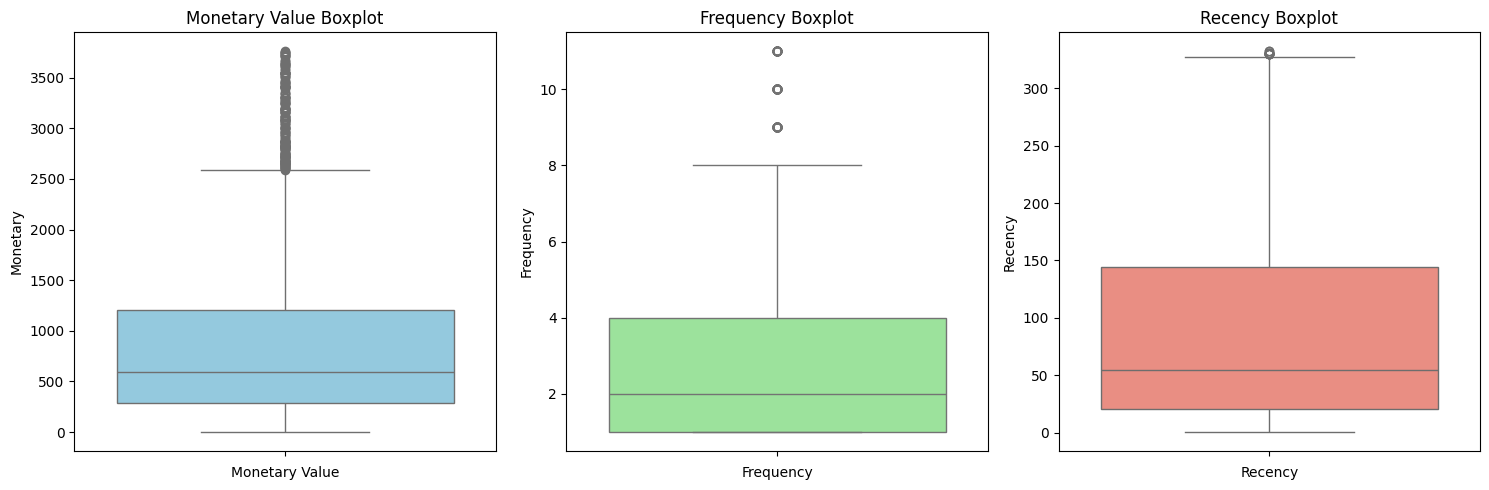

In [22]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outlier_rfm_df['Monetary'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outlier_rfm_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outlier_rfm_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

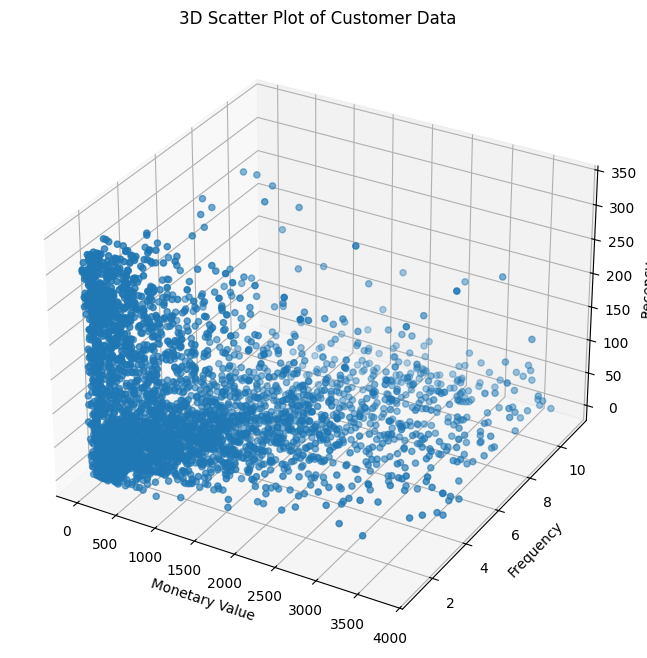

In [23]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outlier_rfm_df["Monetary"], non_outlier_rfm_df["Frequency"], non_outlier_rfm_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

In [24]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_outlier_rfm_df[["Monetary", "Frequency", "Recency"]])
scaled_data_df = pd.DataFrame(scaled_data, columns=["Monetary", "Frequency", "Recency"])

In [25]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components =2)
reduced_feature = svd.fit_transform(scaled_data_df)

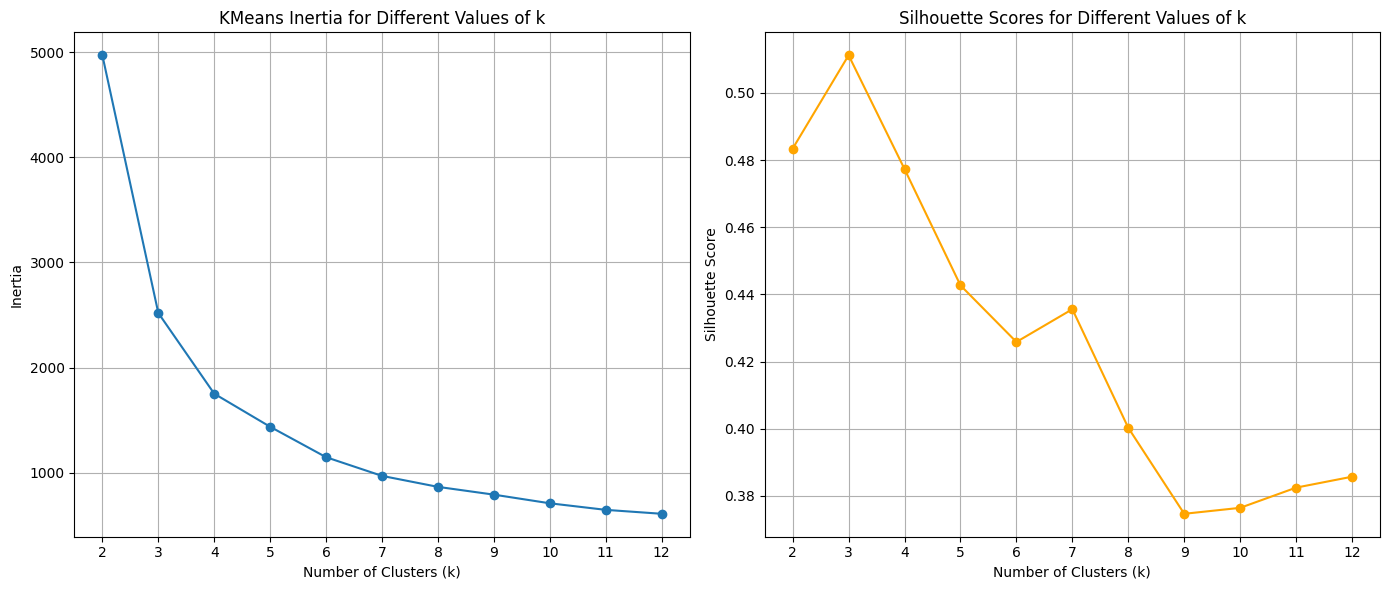

In [26]:
max_k = 12

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(reduced_feature)

    sil_score = silhouette_score(reduced_feature, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

After evaluating the clustering performance using both the Elbow Curve and Silhouette Score, it is evident that k = 3 is the optimal number of clusters. The Elbow Curve showed a significant change in the inertia (within-cluster sum of squares) at k = 3, indicating a clear point where the clustering model achieves a good balance between the number of clusters and the variance explained. Moreover, the Silhouette Score for k = 3 reached its highest value of 0.51, which reflects well-separated clusters with a high degree of cohesion within each cluster. This combination of metrics strongly supports k = 3 as the best choice for clustering, providing both a meaningful partition of the data and a reliable cluster structure.

In [27]:
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(reduced_feature)
non_outlier_rfm_df["Cluster"] = cluster_labels

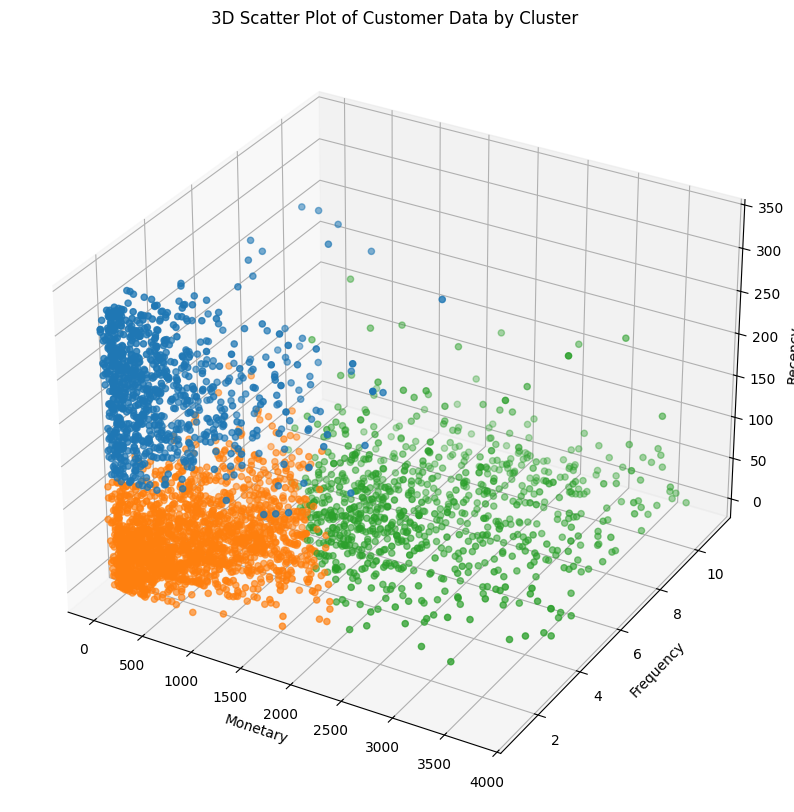

In [28]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = non_outlier_rfm_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outlier_rfm_df['Monetary'],
                     non_outlier_rfm_df['Frequency'],
                     non_outlier_rfm_df['Recency'],
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

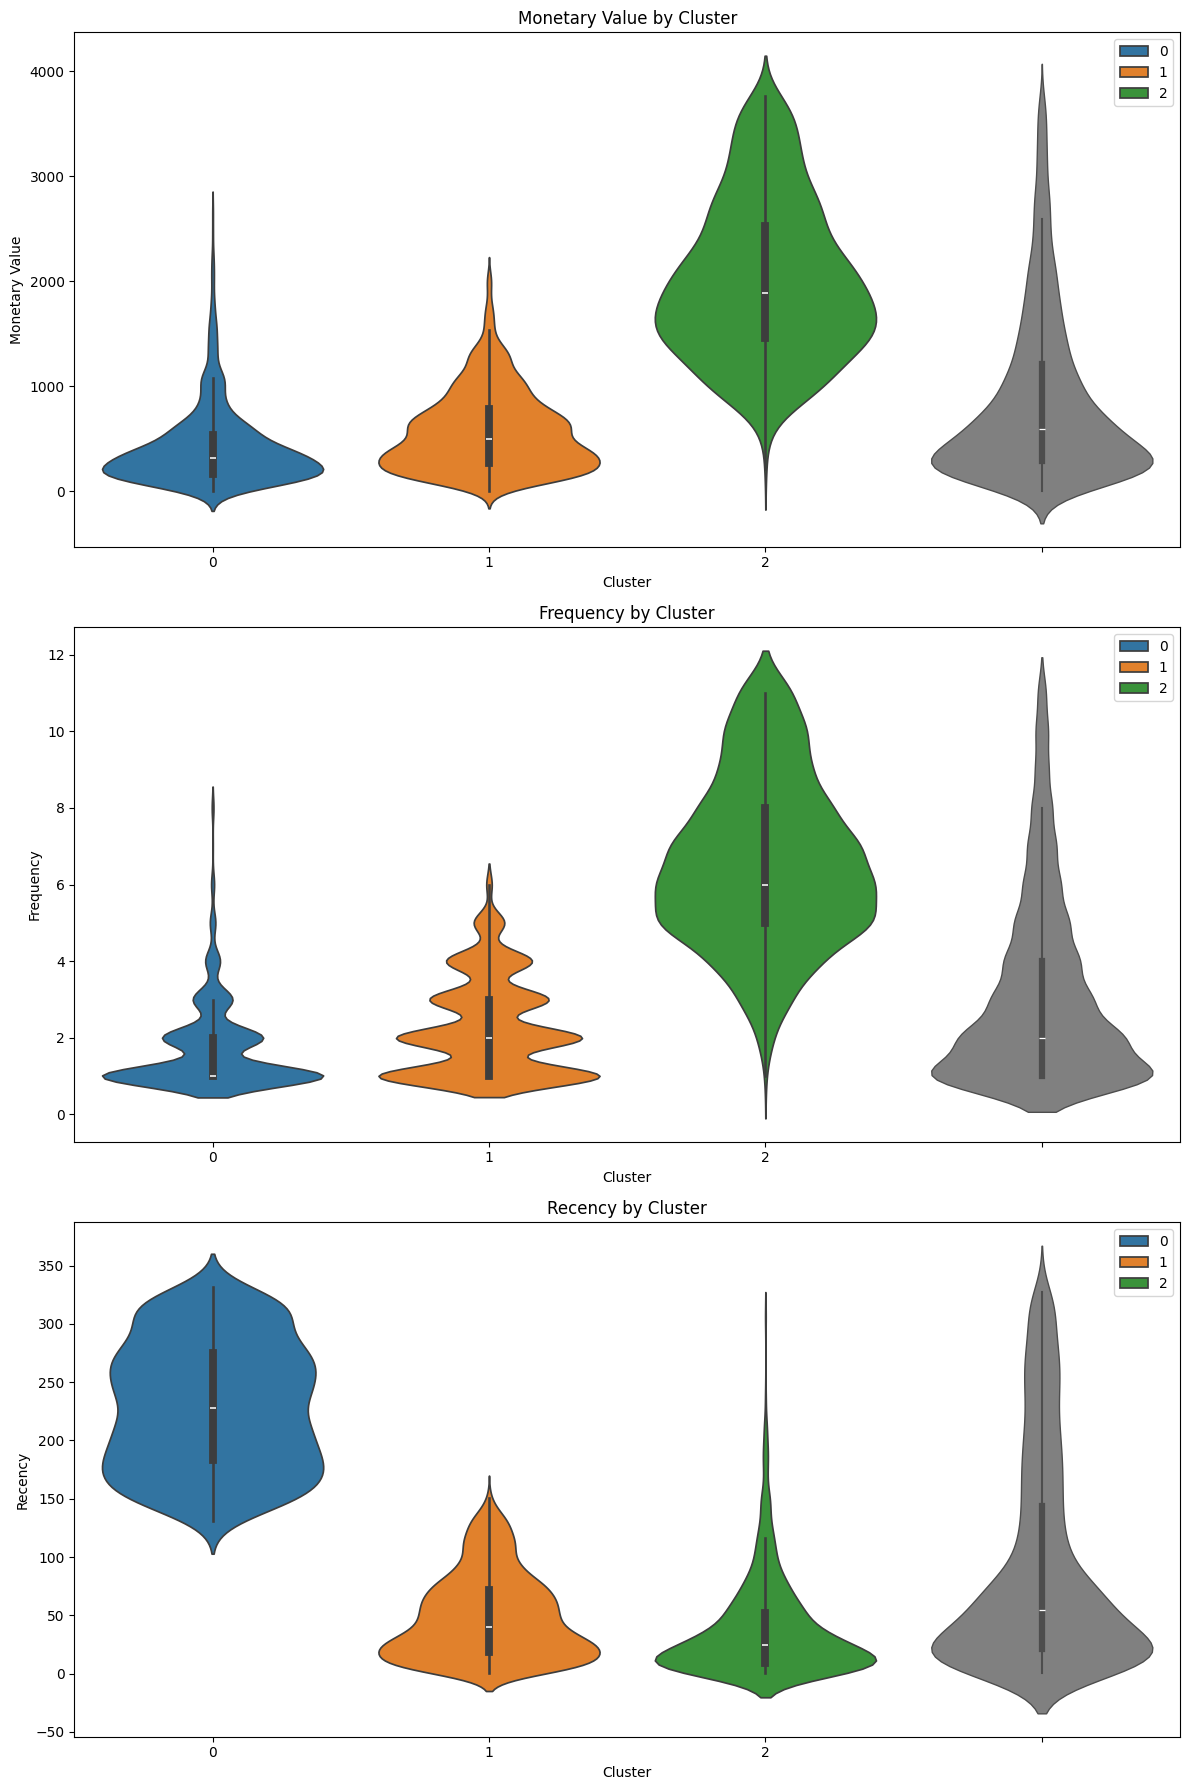

In [29]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outlier_rfm_df['Cluster'], y=non_outlier_rfm_df['Monetary'], palette=cluster_colors, hue=non_outlier_rfm_df["Cluster"])
sns.violinplot(y=non_outlier_rfm_df['Monetary'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outlier_rfm_df['Cluster'], y=non_outlier_rfm_df['Frequency'], palette=cluster_colors, hue=non_outlier_rfm_df["Cluster"])
sns.violinplot(y=non_outlier_rfm_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outlier_rfm_df['Cluster'], y=non_outlier_rfm_df['Recency'], palette=cluster_colors, hue=non_outlier_rfm_df["Cluster"])
sns.violinplot(y=non_outlier_rfm_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [30]:
overlap_indices = outlier_rfm_monetary_df.index.intersection(outlier_rfm_frequency_df.index)

monetary_only_outliers = outlier_rfm_monetary_df.drop(overlap_indices)
frequency_only_outliers = outlier_rfm_frequency_df.drop(overlap_indices)
monetary_and_frequency_outliers = outlier_rfm_monetary_df.loc[overlap_indices]

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

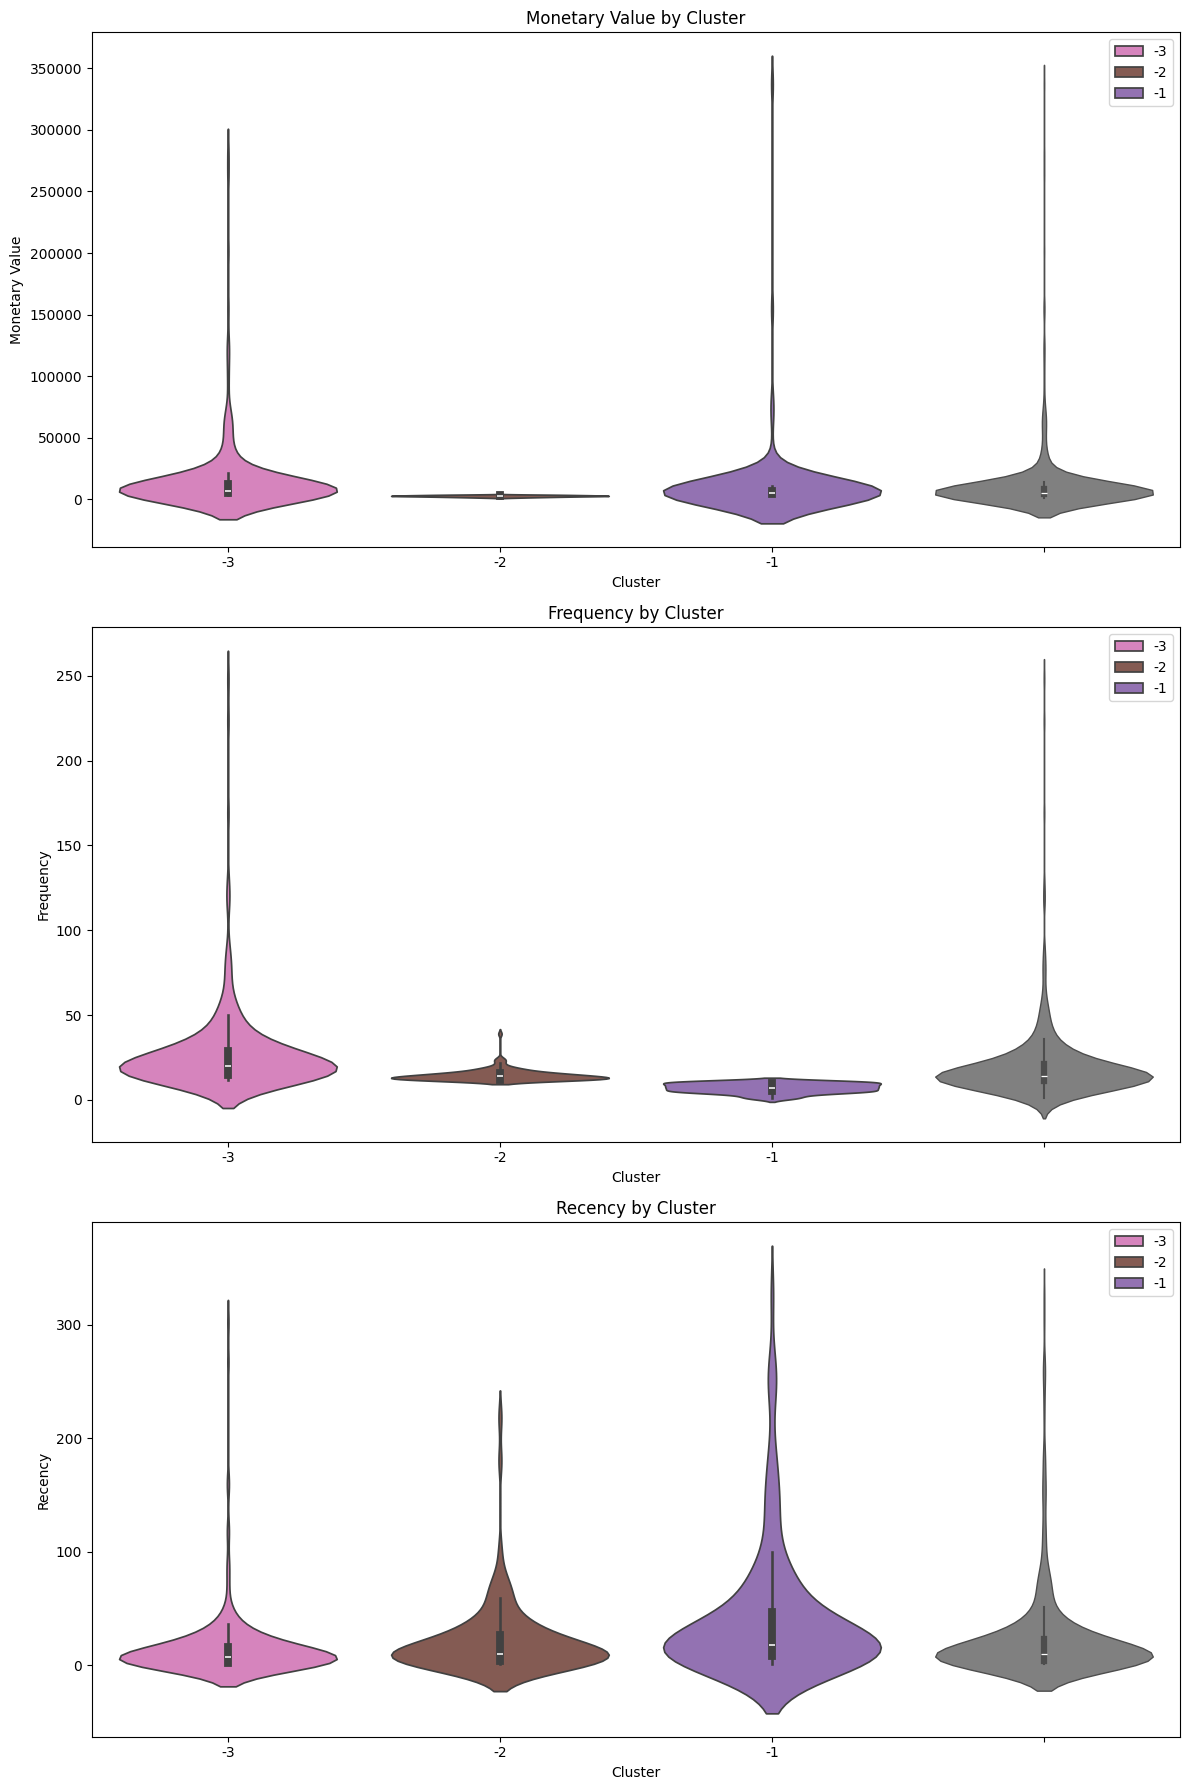

In [31]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Monetary'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Monetary'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

In [32]:
full_clustering_df = pd.concat([non_outlier_rfm_df, outlier_clusters_df])

In [ ]:
data = pd.read_csv('data.csv',encoding='iso-8859-1')
df = df.dropna(subset=['CustomerID'])
df = df[df['UnitPrice']!=0]
df['Quantity'] = df['Quantity'].abs()
df.drop_duplicates(inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Create RFM table
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum',  # Monetary
}).reset_index()
rfm_df = rfm_df.drop(columns=['CustomerID'])
rfm_df.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)
def detect_outliers(column, threshold=1.5):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return (column < lower_bound) | (column > upper_bound)
# Detect outliers for each RFM column
recency_outliers = detect_outliers(rfm_df['Recency'])
frequency_outliers = detect_outliers(rfm_df['Frequency'])
monetary_outliers = detect_outliers(rfm_df['Monetary'])
# Create separate dataframes for outliers and non-outliers
non_outlier_rfm_df = rfm_df[~(recency_outliers | frequency_outliers | monetary_outliers)].copy()
outlier_rfm_recency_df = rfm_df[recency_outliers].copy()
outlier_rfm_frequency_df = rfm_df[frequency_outliers].copy()
outlier_rfm_monetary_df = rfm_df[monetary_outliers].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_outlier_rfm_df[["Monetary", "Frequency", "Recency"]])
scaled_data_df = pd.DataFrame(scaled_data, columns=["Monetary", "Frequency", "Recency"])
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components =2)
reduced_feature = svd.fit_transform(scaled_data_df)
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=1000)
cluster_labels = kmeans.fit_predict(reduced_feature)
non_outlier_rfm_df["Cluster"] = cluster_labels
overlap_indices = outlier_rfm_monetary_df.index.intersection(outlier_rfm_frequency_df.index)

monetary_only_outliers = outlier_rfm_monetary_df.drop(overlap_indices)
frequency_only_outliers = outlier_rfm_frequency_df.drop(overlap_indices)
monetary_and_frequency_outliers = outlier_rfm_monetary_df.loc[overlap_indices]

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])
full_clustering_df = pd.concat([non_outlier_rfm_df, outlier_clusters_df])
# Create a mapping dictionary
cluster_mapping = {
    0: "Potential",
    1: "Frequent",
    2: "Loyal",
    -1: "Inconsistent",
    -2: "Dormant",
    -3: "Bulk Purchase"
}
full_clustering_df.rename(columns={'Cluster': 'Customer'}, inplace=True)
full_clustering_df['Customer'] = full_clustering_df['Customer'].map(cluster_mapping)

In [34]:
# Create a mapping dictionary
cluster_mapping = {
    0: "Potential",
    1: "Frequent",
    2: "Loyal",
    -1: "Inconsistent",
    -2: "Dormant",
    -3: "Bulk Purchase"
}
full_clustering_df.rename(columns={'Cluster': 'Customer'}, inplace=True)

In [35]:
full_clustering_df['Customer'] = full_clustering_df['Customer'].map(cluster_mapping)

In [40]:
full_clustering_df['Customer'].value_counts()

Customer
Frequent         1908
Potential         918
Loyal             857
Bulk Purchase     282
Inconsistent      142
Dormant           115
Name: count, dtype: int64